# Using Python tools for a analysis of COVID-19 data

# ARIMA method to forecast

#### Source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler

In [2]:
mpl.rcParams['font.size'] = 15.0

In [3]:
pd.set_option("display.precision", 5)
pd.set_option('display.max_rows', 15)

### <span style="color:red">Analysis of the last N days</span>

In [4]:
Ndays = '150days'

### <span style="color:red">Day range for matplotlib</span>

In [5]:
Ninterval = 10

In [6]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

In [7]:
#filename = '/home/davi/Documents/Python/Covid-19-Data/owid-covid-data.csv'

In [8]:
df = pd.read_csv(url)
# df = pd.read_csv(filename)
df['date'] = pd.to_datetime(df['date'])
df['location'] = df['location'].replace(['United States'],'United_States')
df['location'] = df['location'].replace(['United Kingdom'],'United_Kingdom')

In [9]:
df = df.loc[:,['date', 'location', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
df = df[df['date'] > pd.to_datetime("today") - pd.to_timedelta(Ndays)]
df = df.sort_values(by=['total_cases'], ascending=True)

# Number of cases and deaths in World

In [10]:
dfWorld = df[df['location'] == 'World']
dfWorld = dfWorld.sort_values(by='date', ascending=True)
dfWorld = dfWorld.loc[:,['date', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
dfWorld.reset_index(drop=True, inplace=True)
dfWorld.tail(15)

,date,total_cases,total_deaths,new_cases,new_deaths
134,2020-08-08,19371784.0,715978.0,275890.0,6465.0
135,2020-08-09,19640034.0,721599.0,268250.0,5621.0
136,2020-08-10,19869310.0,726409.0,229276.0,4810.0
137,2020-08-11,20089784.0,731249.0,220474.0,4840.0
138,2020-08-12,20350846.0,737373.0,261062.0,6124.0
139,2020-08-13,20639861.0,744263.0,289015.0,6890.0
140,2020-08-14,20926766.0,754185.0,286905.0,9922.0
141,2020-08-15,21216009.0,760439.0,289243.0,6254.0
142,2020-08-16,21475412.0,766095.0,259403.0,5656.0
143,2020-08-17,21707557.0,770317.0,232145.0,4222.0


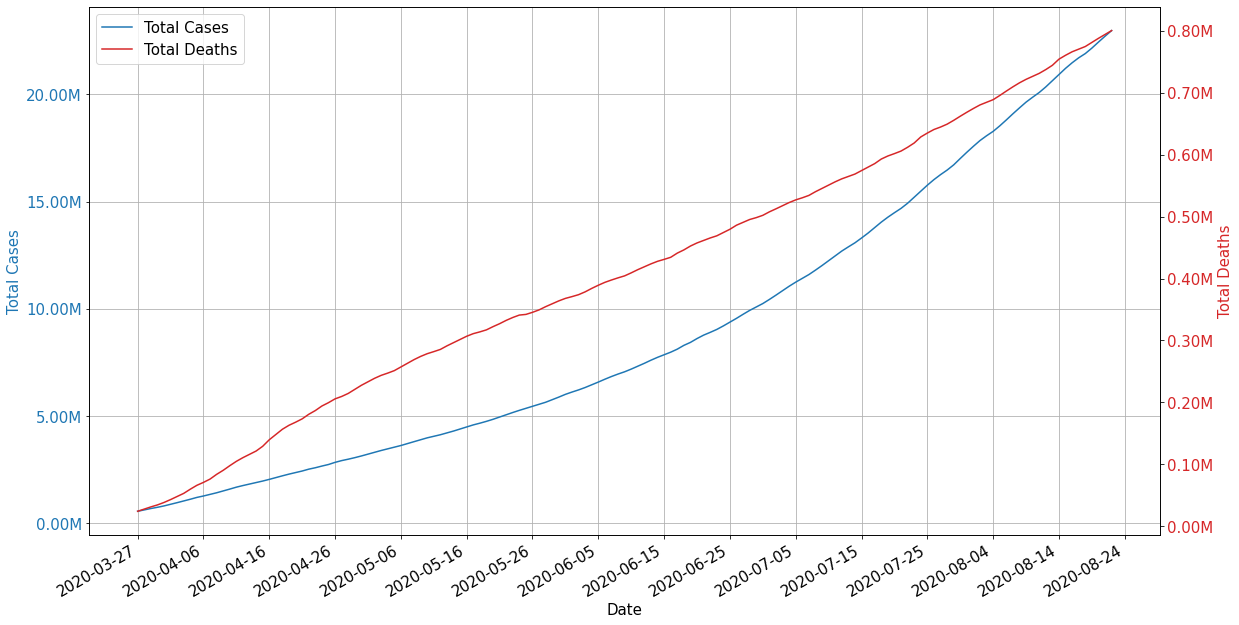

In [11]:
fig, ax1 = plt.subplots(figsize=(19.20,10.80))

color = 'tab:blue'
ax1.plot(dfWorld.date, dfWorld.total_cases, color=color, label='Total Cases')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ticklabel_format(style='plain', axis='y')
plt.grid()
ax2 = ax1.twinx()

color = 'tab:red'
ax2.plot(dfWorld.date, dfWorld.total_deaths, color=color, label = 'Total Deaths')
ax2.set_xlabel('Date')
ax2.set_ylabel('Total Deaths', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000000) + 'M'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000000) + 'M'))
plt.gcf().autofmt_xdate()

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

plt.show()

###  Daily deaths [WORLD]

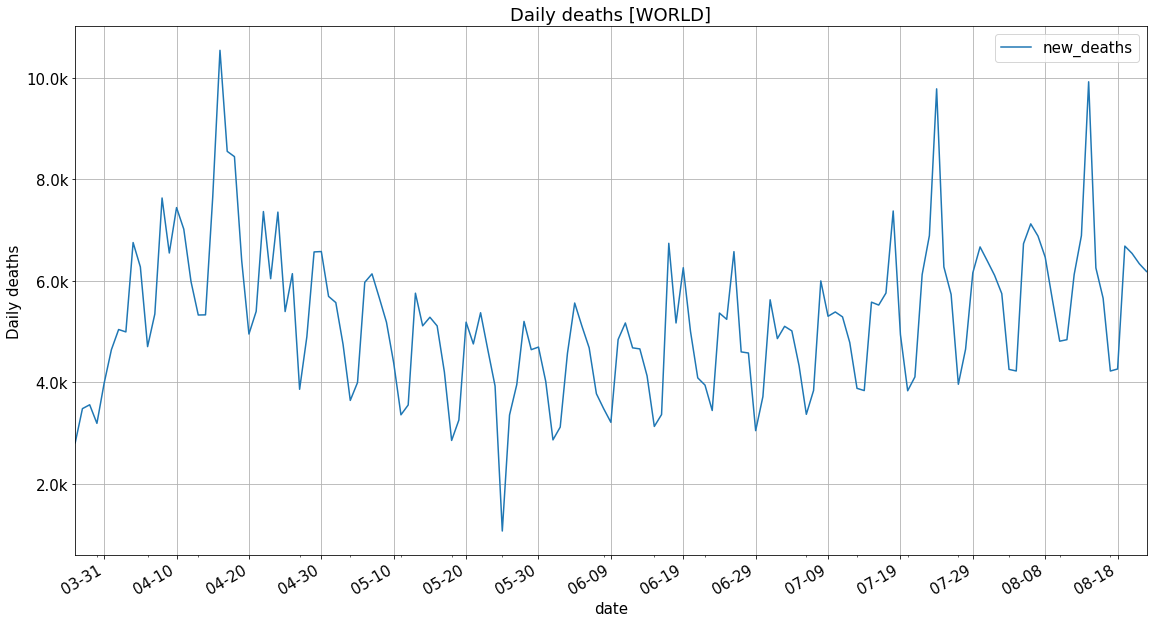

In [12]:
dfWorld.plot(x='date', y='new_deaths', figsize=(19.20,10.80))

plt.ylabel('Daily deaths')
plt.title('Daily deaths [WORLD]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.gcf().autofmt_xdate()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.1f}'.format(y/1000) + 'k'))

plt.grid()
plt.show()

### Daily cases [WORLD]

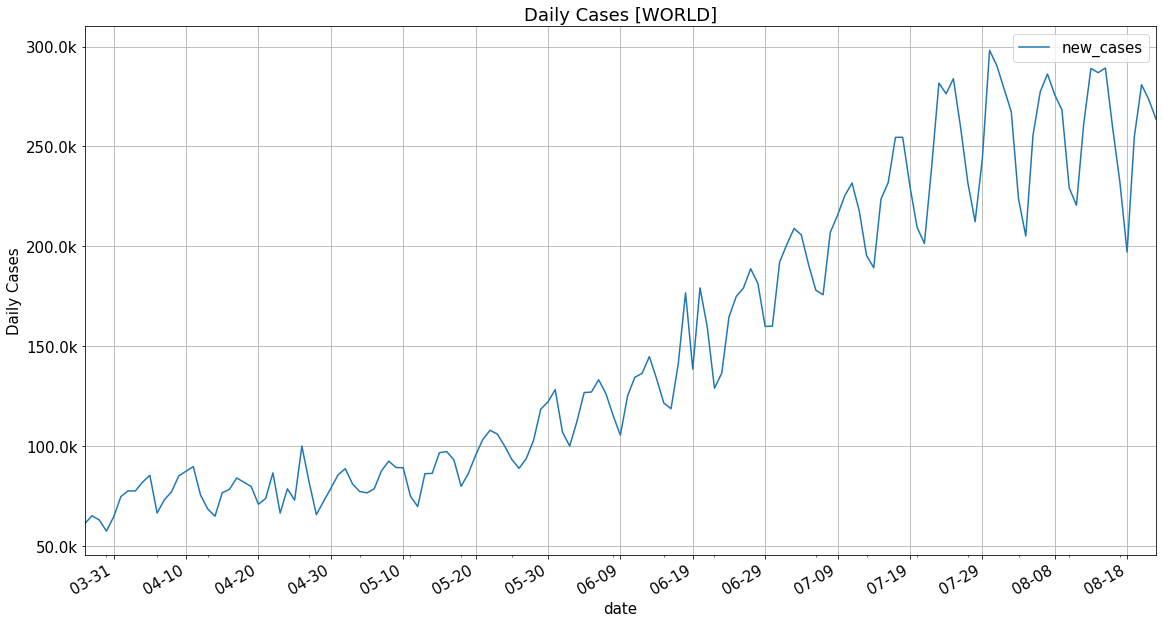

In [13]:
dfWorld.plot(x='date', y='new_cases', figsize=(19.20,10.80))

plt.ylabel('Daily Cases')
plt.title('Daily Cases [WORLD]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.gcf().autofmt_xdate()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.1f}'.format(y/1000) + 'k'))

plt.grid()
plt.show()

In [14]:
dfFilter = df.loc[:,['date', 'location', 'total_cases', 'total_deaths']]
dfFilter = dfFilter[
        (df['location'] != 'World') &
        (df['location'] != 'International')
]

In [15]:
dfToday = dfFilter[dfFilter['date'] == dfFilter['date'].max()]

In [16]:
sumCases = dfToday.groupby(['location']).sum()
sumCases.reset_index(level=0, inplace=True)
sumCases.loc[sumCases['total_cases'] <= 500000, ['location']] = 'Other_Countries'

#### <span style="color:green">Countries with less than 500k cases are grouped under "Other_Countries"</span>

In [17]:
sumCases = sumCases.groupby(['location']).sum()
sumCases = sumCases.sort_values(by=['total_cases'], ascending=False)
sumCases

,total_cases,total_deaths
location,,
Other_Countries,7260638.0,294463.0
United_States,5623727.0,175406.0
Brazil,3532330.0,113358.0
India,2975701.0,55794.0
Russia,946976.0,16189.0
South Africa,603338.0,12843.0
Peru,576067.0,27245.0
Mexico,549734.0,59610.0
Colombia,522138.0,16568.0


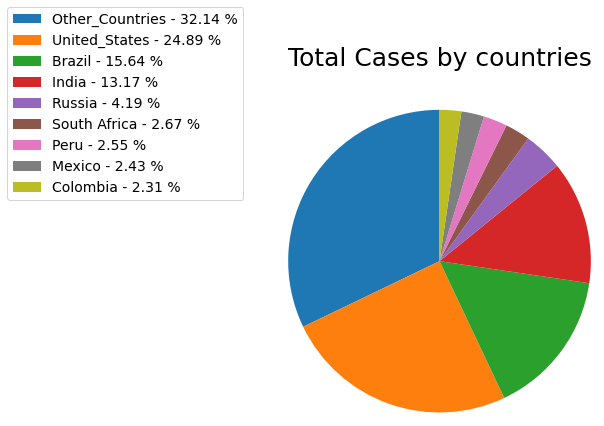

In [18]:
x = sumCases.index
y = sumCases.total_cases

porcent = 100.*y/y.sum()
fig = plt.figure(figsize=(10.20,5.80))
patches, texts = plt.pie(y, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.), fontsize=14)
plt.title('Total Cases by countries', fontsize=25, y=1.1)
plt.show()

#### USA has 25% of all cases of COVID-19 in the world

##  COVID-19 cases and deaths in the most affected countries

#### <span style="color:red">Selecting Countries by the following conditions: 50k total cases and 35k deaths</span> 

In [19]:
numberCases = 50000
numberDeaths = 35000

In [20]:
mainCountries = df[
        (df['total_cases'] >= numberCases) & 
        (df['total_deaths'] >= numberDeaths) &
        (df['location'] != 'World') &
        (df['location'] != 'International')
]
mainCountries = mainCountries.sort_values(by=['total_cases'], ascending=False)
mainCountries = mainCountries.dropna()
mainCountries

,date,location,total_cases,total_deaths,new_cases,new_deaths
36776,2020-08-22,United_States,5623727.0,175406.0,49880.0,1151.0
36775,2020-08-21,United_States,5573847.0,174255.0,44005.0,1078.0
36774,2020-08-20,United_States,5529842.0,173177.0,47426.0,1356.0
36773,2020-08-19,United_States,5482416.0,171821.0,44091.0,1324.0
36772,2020-08-18,United_States,5438325.0,170497.0,35056.0,445.0
...,...,...,...,...,...,...
17977,2020-07-18,Italy,243967.0,35028.0,231.0,11.0
17976,2020-07-17,Italy,243736.0,35017.0,230.0,20.0
36450,2020-05-24,United_Kingdom,243081.0,35578.0,2062.0,220.0
36449,2020-05-23,United_Kingdom,241019.0,35358.0,2574.0,291.0


In [21]:
dfCountry = mainCountries['location'].astype(str).unique()
pd.DataFrame(dfCountry)

,0
0,United_States
1,Brazil
2,India
3,Mexico
4,United_Kingdom
5,Italy


In [22]:
d = {}
for index in range(len(dfCountry)):
    d[index] = df[df['location'] == dfCountry[index]]
    d[index].reset_index(drop=True, inplace=True)

In [23]:
totalCases_list=[]
totalDeaths_list=[]
newCases_list=[]
newDeaths_list=[]

for index in range(len(dfCountry)):  
    
    totalCases = [d[index]['total_cases']]
    totalDeaths = [d[index]['total_deaths']]
    newCases = [d[index]['new_cases']]
    newDeaths = [d[index]['new_deaths']]
    
    header = [dfCountry[index]]
    
    totalCases = pd.concat(totalCases, axis=1, keys=header)
    totalDeaths = pd.concat(totalDeaths, axis=1, keys=header)
    newCases = pd.concat(newCases, axis=1, keys=header)
    newDeaths = pd.concat(newDeaths, axis=1, keys=header)
    
    totalCases_list.append(totalCases)
    totalDeaths_list.append(totalDeaths)
    newCases_list.append(newCases)
    newDeaths_list.append(newDeaths)

In [24]:
timestamps = sorted(set(dfWorld.loc[:, 'date'].values))

In [25]:
dfTotalCases=[]
dfTotalDeaths=[]
dfNewCases=[]
dfNewDeaths=[]

for index in range(len(dfCountry)):
    dfTotalCases = pd.concat(totalCases_list, axis=1)
    dfTotalDeaths = pd.concat(totalDeaths_list, axis=1)
    dfNewCases = pd.concat(newCases_list, axis=1)
    dfNewDeaths = pd.concat(newDeaths_list,axis=1)
    
dfTotalCases.insert(0, 'date', timestamps)
dfTotalDeaths.insert(0, 'date', timestamps)
dfNewCases.insert(0, 'date', timestamps)
dfNewDeaths.insert(0, 'date', timestamps)

### <ins>Total cases</ins> in the most affected countries

In [26]:
dfTotalCases.sort_values(by=['date'], ascending=True)

,date,United_States,Brazil,India,Mexico,United_Kingdom,Italy
0,2020-03-27,85991.0,2915.0,724.0,585.0,17717.0,80539.0
1,2020-03-28,104686.0,3417.0,873.0,717.0,20804.0,86498.0
2,2020-03-29,124665.0,3904.0,979.0,848.0,24001.0,92472.0
3,2020-03-30,143025.0,4256.0,1071.0,993.0,26823.0,97689.0
4,2020-03-31,164620.0,4579.0,1251.0,1094.0,29681.0,101739.0
...,...,...,...,...,...,...,...
144,2020-08-18,5438325.0,3359570.0,2702742.0,525733.0,319197.0,254235.0
145,2020-08-19,5482416.0,3407354.0,2767273.0,531239.0,320286.0,254636.0
146,2020-08-20,5529842.0,3456652.0,2836925.0,537031.0,321098.0,255278.0
147,2020-08-21,5573847.0,3501975.0,2905823.0,543806.0,322280.0,256118.0


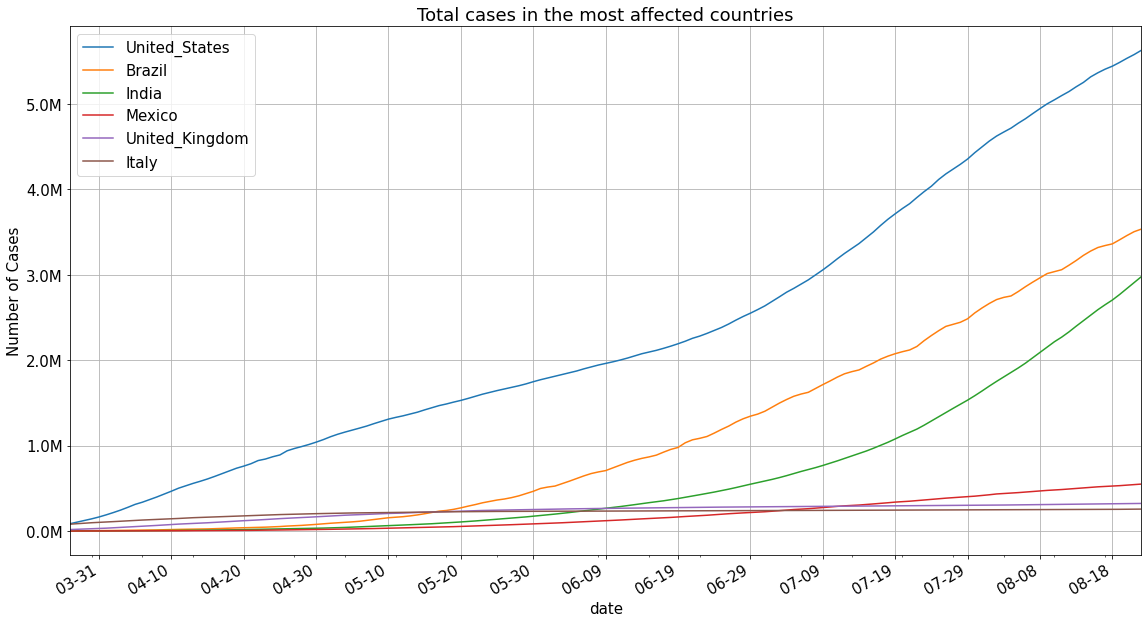

In [27]:
dfTotalCases.plot(x='date', y=dfCountry, figsize=(19.20,10.80))

plt.ylabel('Number of Cases')
plt.title('Total cases in the most affected countries')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.gcf().autofmt_xdate()

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.1f}'.format(y/1000000) + 'M'))

plt.grid()
plt.show()

#### Log analysis - log<sub>b</sub><sup>x</sup>

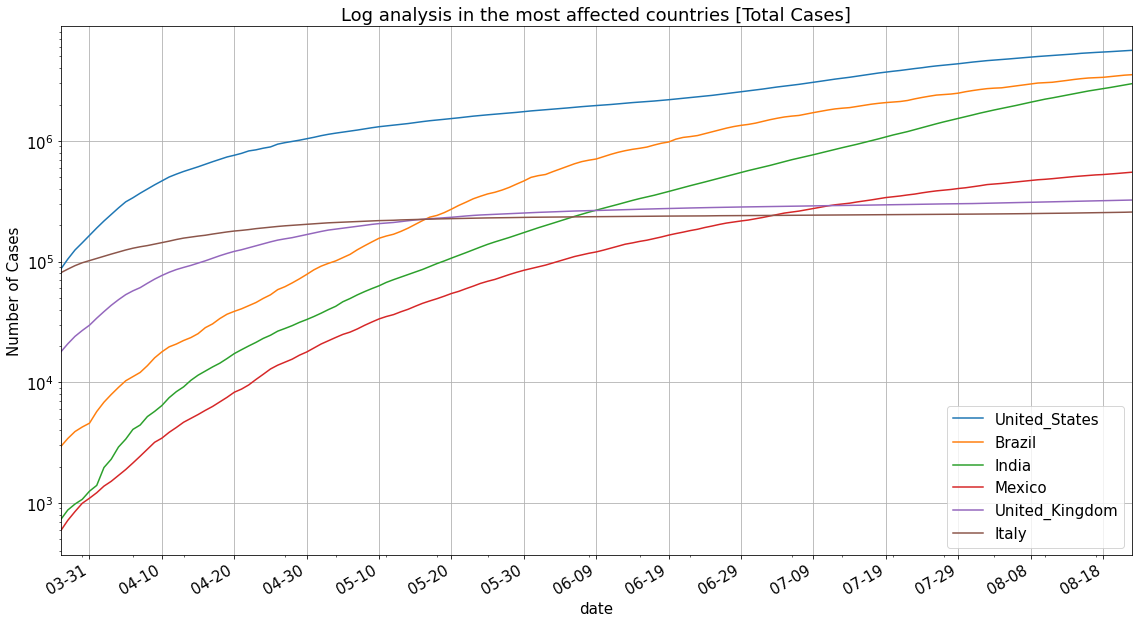

In [28]:
dfTotalCases.plot(x='date', y=dfCountry, logx=False, logy=True, figsize=(19.20,10.80))

plt.ylabel('Number of Cases')
plt.title('Log analysis in the most affected countries [Total Cases]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

### <ins>Total Deaths</ins> in the most affected countries

In [29]:
dfTotalDeaths.sort_values(by=['date'], ascending=True)

,date,United_States,Brazil,India,Mexico,United_Kingdom,Italy
0,2020-03-27,1296.0,77.0,17.0,8.0,884.0,8165.0
1,2020-03-28,1707.0,92.0,19.0,12.0,1172.0,9136.0
2,2020-03-29,2191.0,114.0,25.0,16.0,1464.0,10023.0
3,2020-03-30,2509.0,136.0,29.0,20.0,1676.0,10781.0
4,2020-03-31,3170.0,159.0,32.0,28.0,2050.0,11591.0
...,...,...,...,...,...,...,...
144,2020-08-18,170497.0,108536.0,51797.0,57023.0,41369.0,35400.0
145,2020-08-19,171821.0,109888.0,52889.0,57774.0,41381.0,35405.0
146,2020-08-20,173177.0,111100.0,53866.0,58481.0,41397.0,35412.0
147,2020-08-21,174255.0,112304.0,54849.0,59106.0,41403.0,35418.0


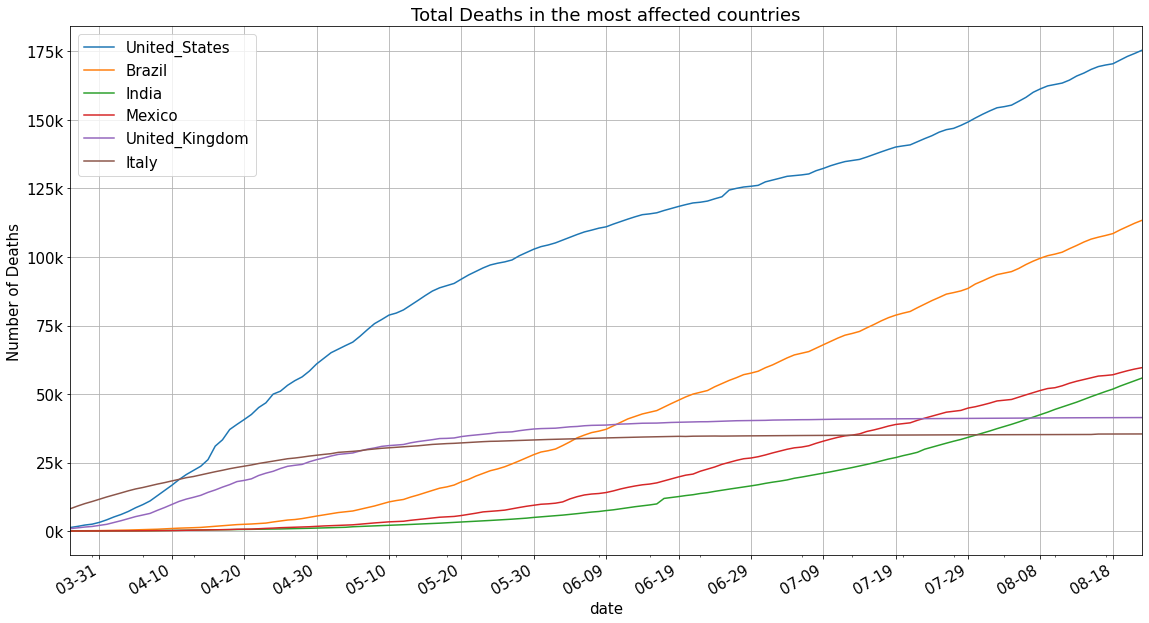

In [30]:
dfTotalDeaths.plot(x='date', y=dfCountry, figsize=(19.20,10.80))

plt.ylabel('Number of Deaths')
plt.title('Total Deaths in the most affected countries')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/1000) + 'k'))

plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

#### Log analysis - log<sub>b</sub><sup>x</sup>

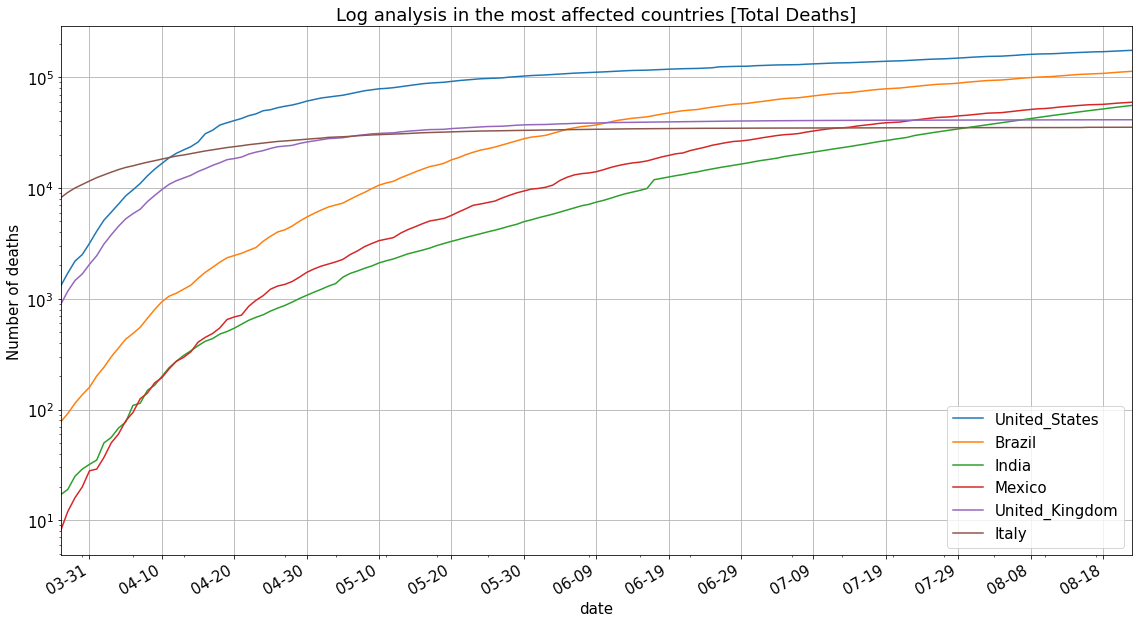

In [31]:
dfTotalDeaths.plot(x='date', y=dfCountry, logx=False, logy=True, figsize=(19.20,10.80))

plt.ylabel('Number of deaths')
plt.title('Log analysis in the most affected countries [Total Deaths]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

### Total cases and deaths by country

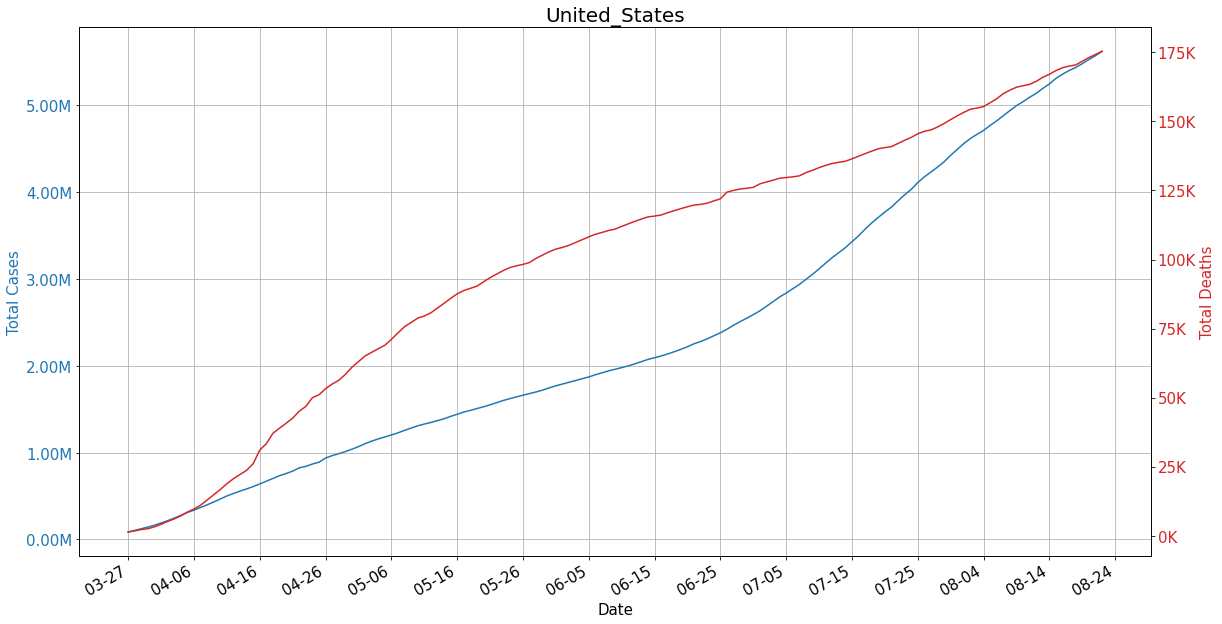

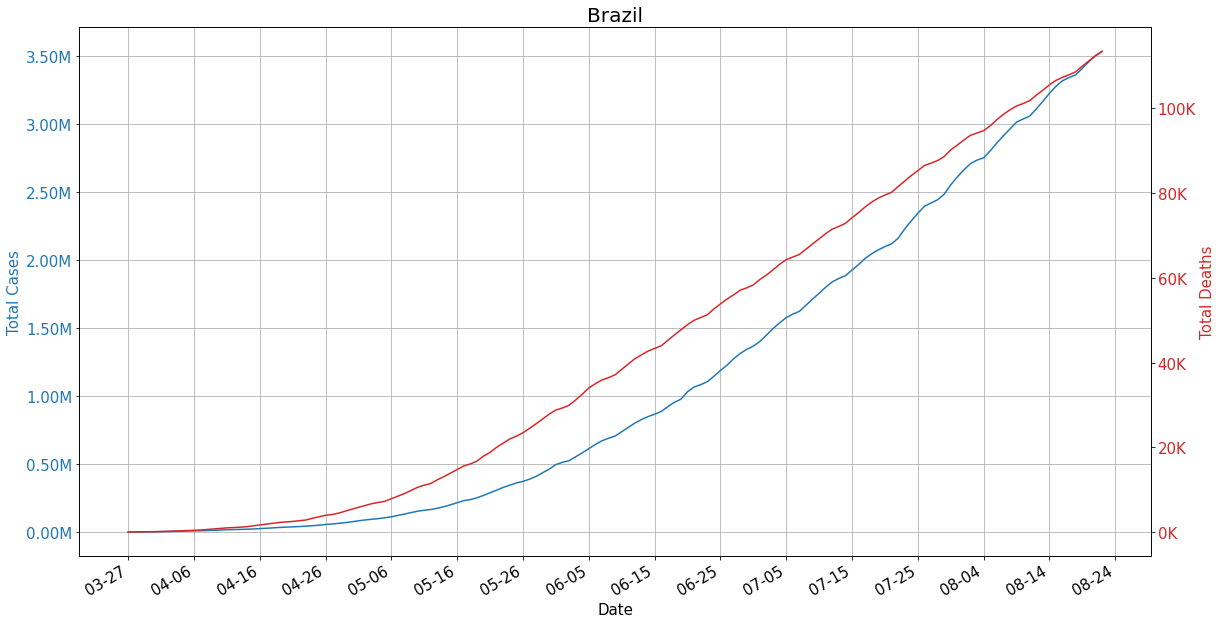

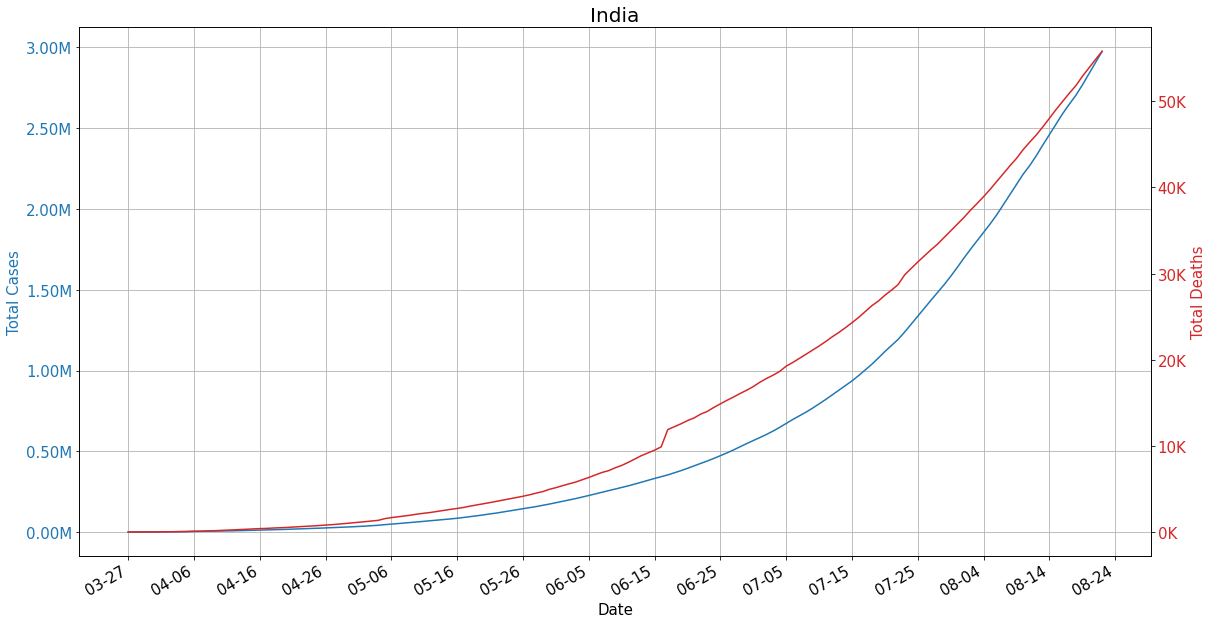

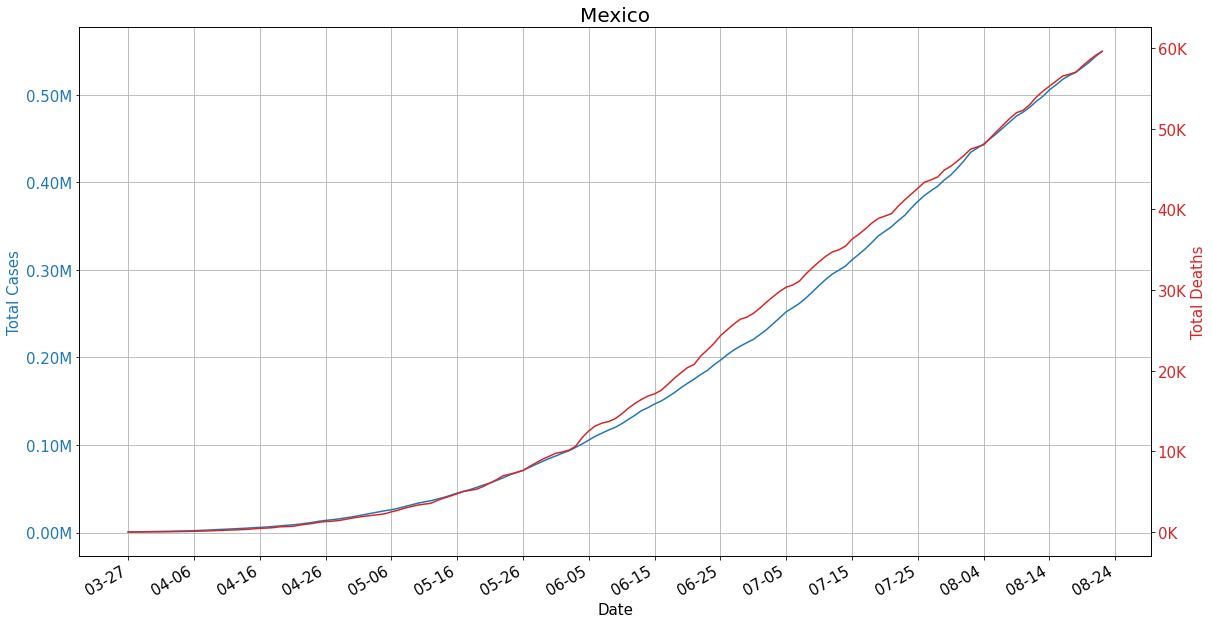

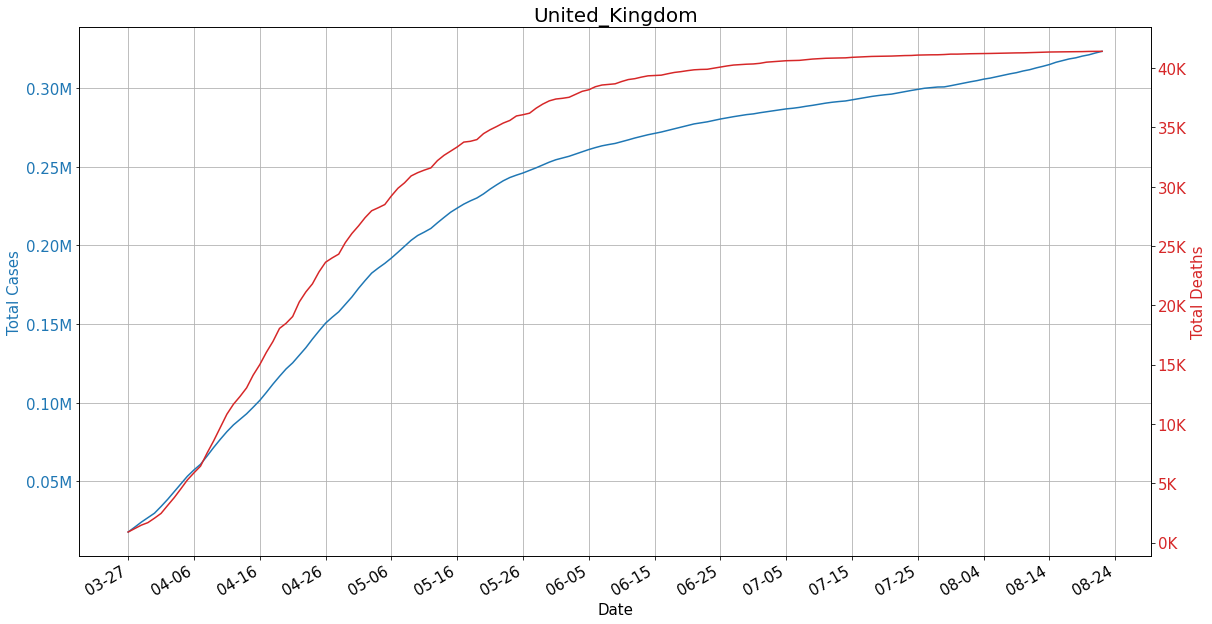

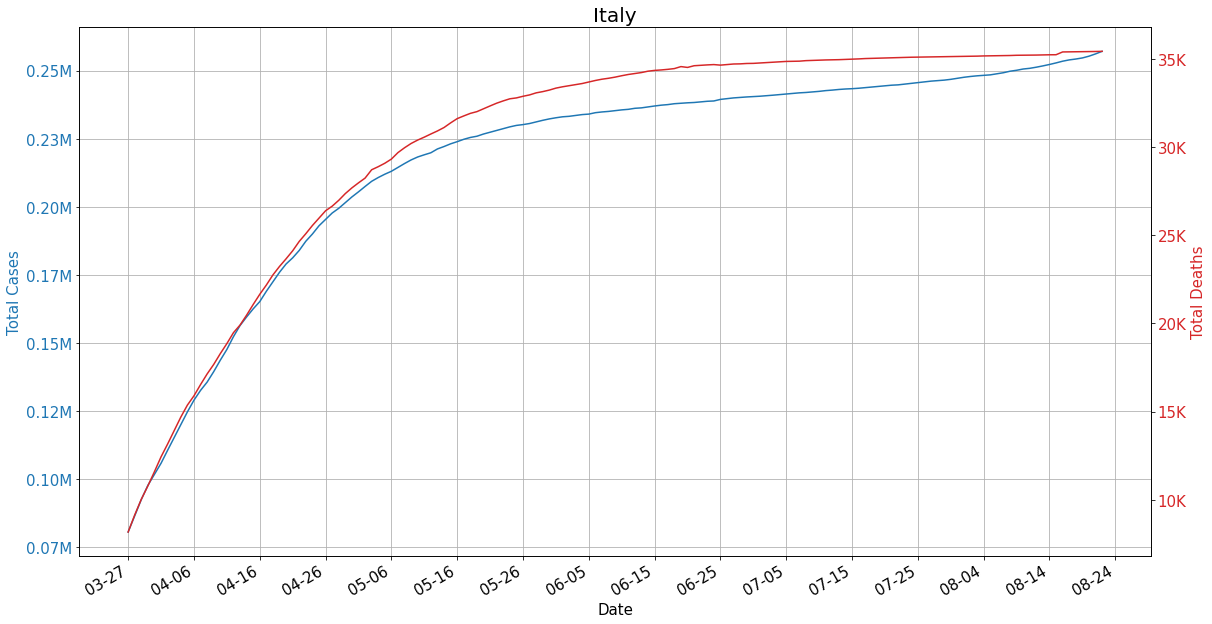

In [32]:
for index in range(1, len(dfCountry)+1,1):
    fig, ax1 = plt.subplots(figsize=(19.20,10.80))
    color = 'tab:blue'
    ax1.plot(dfTotalCases.date, dfTotalCases.iloc[:,index], color=color, label='Total Cases')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Cases', color=color)
    plt.title(dfCountry[index-1], fontsize=20)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.ticklabel_format(style='plain', axis='y')
    
    plt.grid()
    
    ax2 = ax1.twinx()

    color = 'tab:red'
    ax2.plot(dfTotalDeaths.date, dfTotalDeaths.iloc[:,index], color=color, label = 'Total Deaths')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Total Deaths', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
    
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000000) + 'M'))
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/1000) + 'K'))

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    plt.gcf().autofmt_xdate()
    plt.show()

### <ins>Daily Cases</ins> in the most affected countries

In [33]:
dfNewCases.sort_values(by=['date'], ascending=True)

,date,United_States,Brazil,India,Mexico,United_Kingdom,Italy
0,2020-03-27,16797.0,482.0,75.0,110.0,2692.0,6153.0
1,2020-03-28,18695.0,502.0,149.0,132.0,3087.0,5959.0
2,2020-03-29,19979.0,487.0,106.0,131.0,3197.0,5974.0
3,2020-03-30,18360.0,352.0,92.0,145.0,2822.0,5217.0
4,2020-03-31,21595.0,323.0,180.0,101.0,2858.0,4050.0
...,...,...,...,...,...,...,...
144,2020-08-18,35056.0,19373.0,55079.0,3571.0,713.0,320.0
145,2020-08-19,44091.0,47784.0,64531.0,5506.0,1089.0,401.0
146,2020-08-20,47426.0,49298.0,69652.0,5792.0,812.0,642.0
147,2020-08-21,44005.0,45323.0,68898.0,6775.0,1182.0,840.0


In [34]:
# dfNewCases.plot(x='date', y=dfCountry, figsize=(19.20,10.80))

# plt.ylabel('Daily cases')
# plt.title('Daily Cases in the most affected countries')

# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
# plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/1000) + 'k'))
# plt.gcf().autofmt_xdate()

# plt.grid()
# plt.show()

### <ins>Daily Deaths</ins> in the most affected countries

In [35]:
dfNewDeaths.sort_values(by=['date'], ascending=True)

,date,United_States,Brazil,India,Mexico,United_Kingdom,Italy
0,2020-03-27,246.0,20.0,4.0,3.0,181.0,660.0
1,2020-03-28,411.0,15.0,2.0,4.0,288.0,971.0
2,2020-03-29,484.0,22.0,6.0,4.0,292.0,887.0
3,2020-03-30,318.0,22.0,4.0,4.0,212.0,758.0
4,2020-03-31,661.0,23.0,3.0,8.0,374.0,810.0
...,...,...,...,...,...,...,...
144,2020-08-18,445.0,684.0,876.0,266.0,3.0,4.0
145,2020-08-19,1324.0,1352.0,1092.0,751.0,12.0,5.0
146,2020-08-20,1356.0,1212.0,977.0,707.0,16.0,7.0
147,2020-08-21,1078.0,1204.0,983.0,625.0,6.0,6.0


In [36]:
# dfNewDeaths.plot(x='date', y=dfCountry, figsize=(19.20,10.80))

# plt.ylabel('Daily Deaths')
# plt.title('Daily Deaths in the most affected countries')

# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
# plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/1000) + 'k'))
# plt.gcf().autofmt_xdate()

# plt.grid()
# plt.show()

### Daily cases and deaths by country

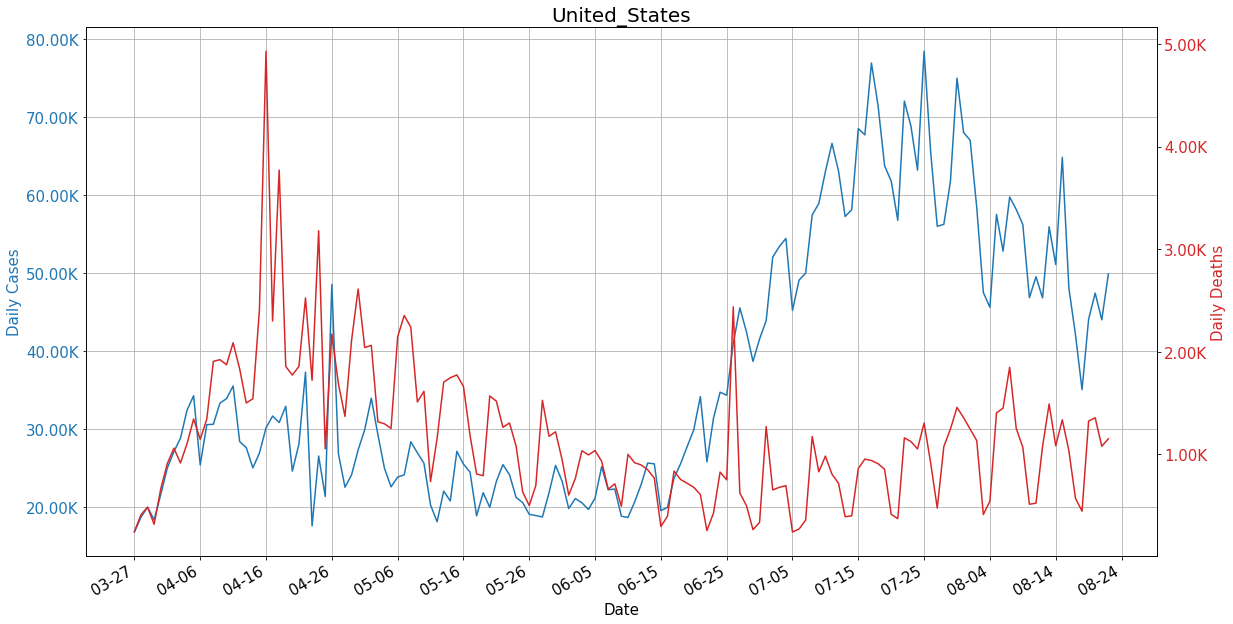

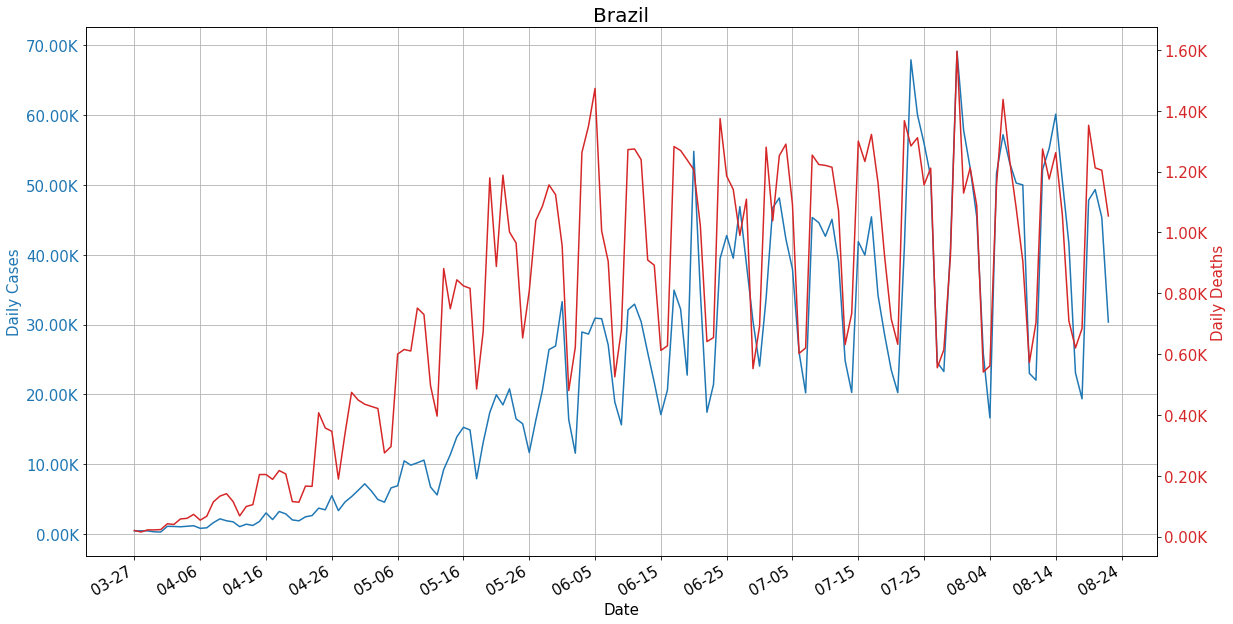

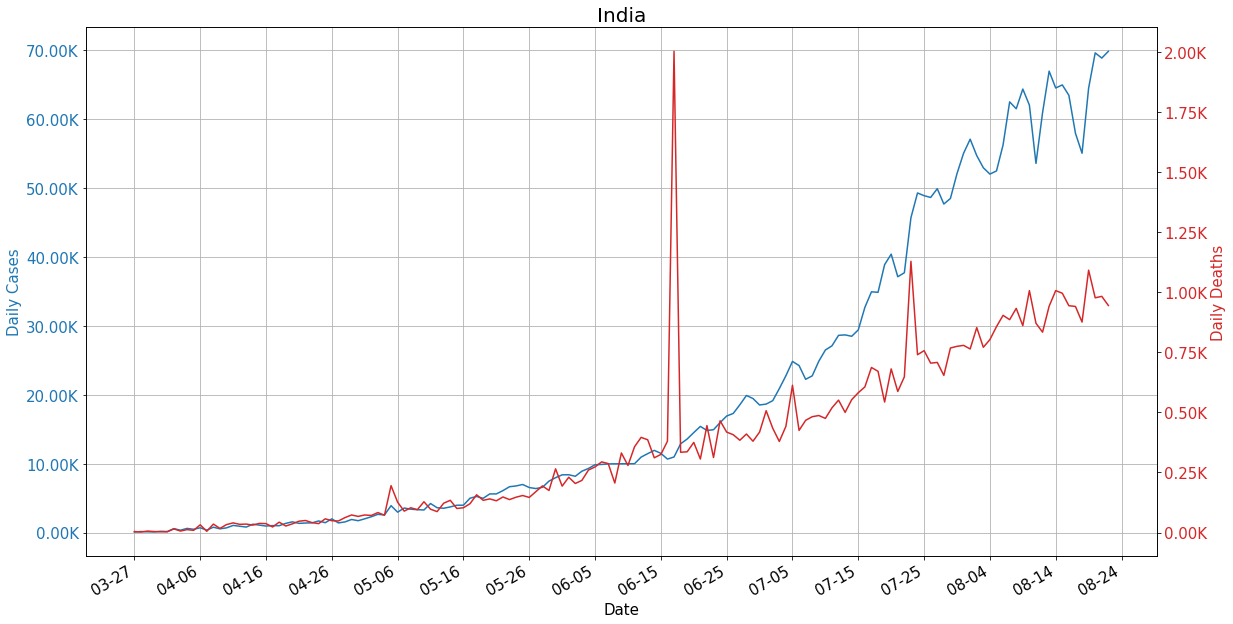

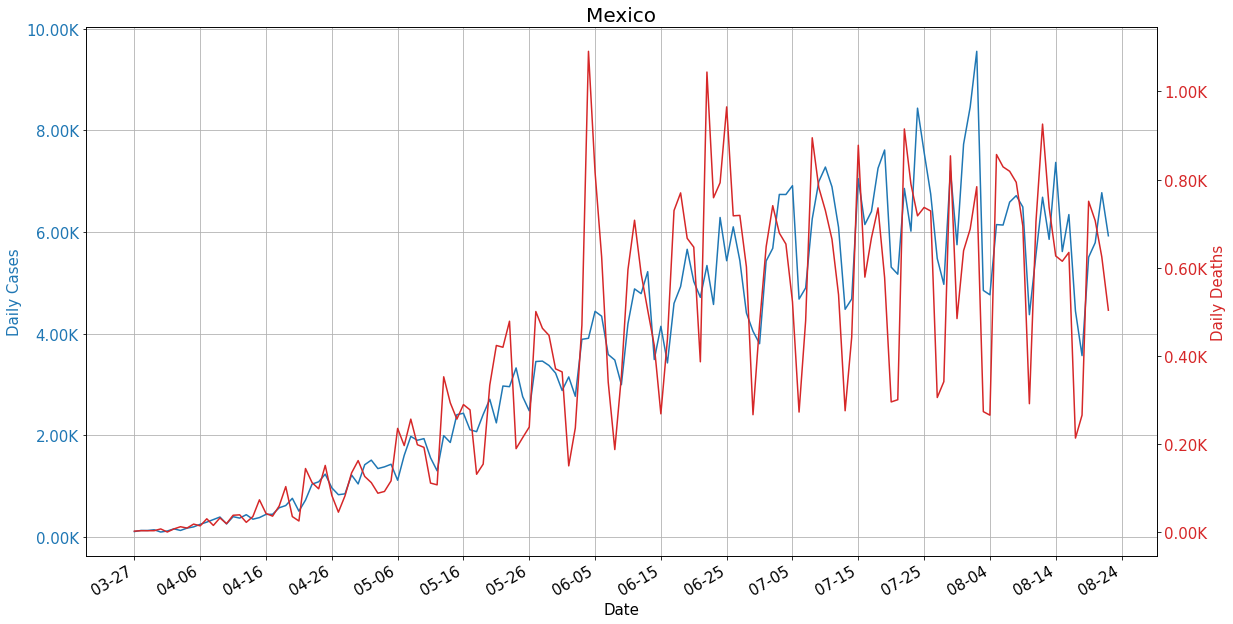

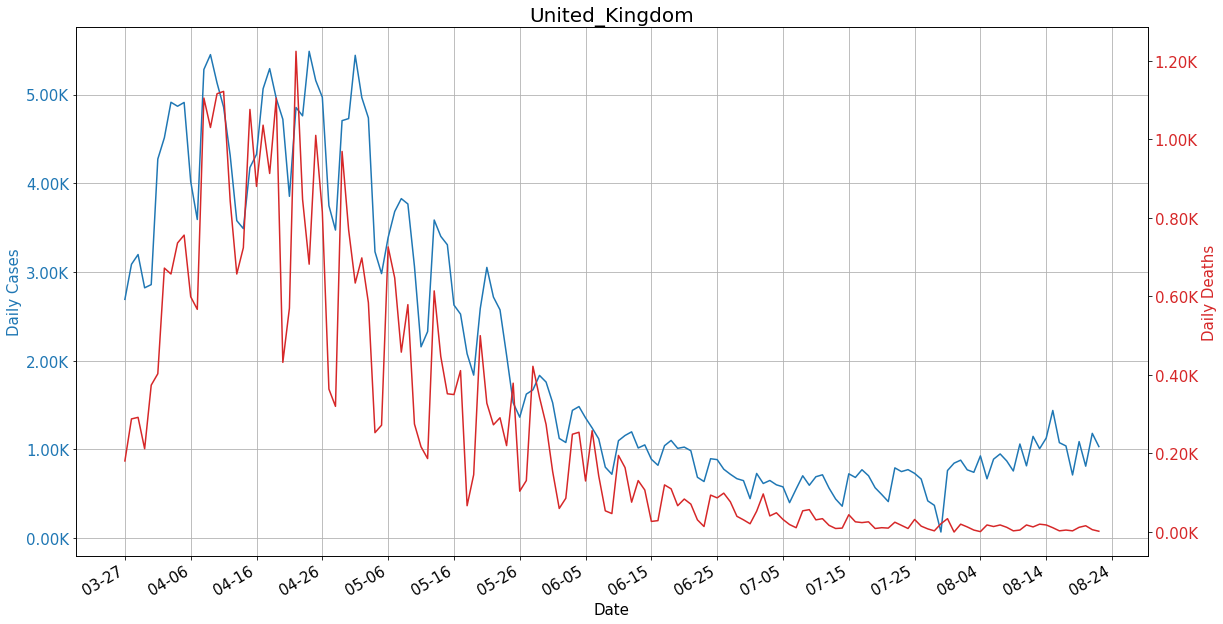

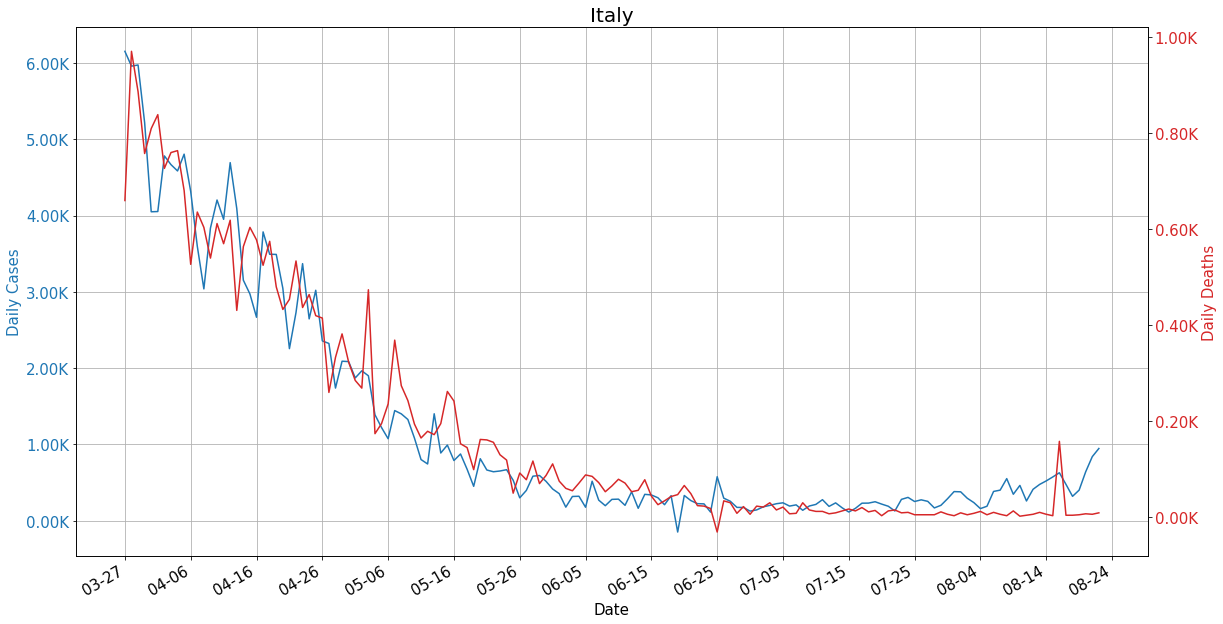

In [37]:
for index in range(1, len(dfCountry)+1,1):
    fig, ax1 = plt.subplots(figsize=(19.20,10.80))
    color = 'tab:blue'
    ax1.plot(dfNewCases.date, dfNewCases.iloc[:,index], color=color, label='Total Cases')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Cases', color=color)
    plt.title(dfCountry[index-1], fontsize=20)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.ticklabel_format(style='plain', axis='y')
    
    plt.grid()
    
    ax2 = ax1.twinx()

    color = 'tab:red'
    ax2.plot(dfNewDeaths.date, dfNewDeaths.iloc[:,index], color=color, label = 'Total Deaths')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Daily Deaths', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
    
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000) + 'K'))
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000) + 'K'))

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

    plt.gcf().autofmt_xdate()
    plt.show()

In [38]:
dfToday = mainCountries[mainCountries['date'] == mainCountries['date'].max()]
dfToday

,date,location,total_cases,total_deaths,new_cases,new_deaths
36776,2020-08-22,United_States,5623727.0,175406.0,49880.0,1151.0
5241,2020-08-22,Brazil,3532330.0,113358.0,30355.0,1054.0
16441,2020-08-22,India,2975701.0,55794.0,69878.0,945.0
23072,2020-08-22,Mexico,549734.0,59610.0,5928.0,504.0
36540,2020-08-22,United_Kingdom,323313.0,41405.0,1033.0,2.0
18012,2020-08-22,Italy,257065.0,35427.0,947.0,9.0


In [39]:
nameColumns = list(dfWorld.columns)
nameColumns

['date', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']

In [40]:
dfWorld = dfWorld.set_index('date')

In [41]:
meanVector = np.mean(dfWorld)
stdVector = np.std(dfWorld)
dfNormalized = (dfWorld-meanVector)/stdVector

In [42]:
meanVector

total_cases     8.82178e+06
total_deaths    4.09352e+05
new_cases       1.50877e+05
new_deaths      5.22695e+03
dtype: float64

In [43]:
dfNormalized

,total_cases,total_deaths,new_cases,new_deaths
date,,,,
2020-03-27,-1.28262,-1.78557,-1.21166,-1.67542
2020-03-28,-1.27253,-1.76942,-1.15853,-1.20879
2020-03-29,-1.26277,-1.75293,-1.18631,-1.15617
2020-03-30,-1.25387,-1.73813,-1.26131,-1.40957
2020-03-31,-1.24387,-1.71966,-1.16600,-0.86123
...,...,...,...,...
2020-08-18,2.03050,1.69369,0.62279,-0.66807
2020-08-19,2.07006,1.72469,1.40267,1.00877
2020-08-20,2.11365,1.75501,1.75286,0.90838


In [44]:
dfNormalized.iloc[:,2]

date
2020-03-27   -1.21166
2020-03-28   -1.15853
2020-03-29   -1.18631
2020-03-30   -1.26131
2020-03-31   -1.16600
               ...   
2020-08-18    0.62279
2020-08-19    1.40267
2020-08-20    1.75286
2020-08-21    1.65293
2020-08-22    1.52004
Name: new_cases, Length: 149, dtype: float64

In [45]:
# dfNormalized[0]

In [46]:
# scaler  = MinMaxScaler(feature_range=(0,1))

In [47]:
# dfScaled = dfWorld
# dfScaled[['total_cases','total_deaths','new_cases','new_deaths']] = scaler.fit_transform(dfWorld[['total_cases','total_deaths','new_cases','new_deaths']])
# # dfScaled = dfScaled.set_index('date')
# dfScaled

In [48]:
# nameColumns = list(dfScaled.columns)

In [49]:
# dfWorld = dfWorld[-180:]

In [50]:
# y={}
# for index in range(len(nameColumns)):
#     y[index] = dfScaled[nameColumns[index]]
#     y[index] = y[index].fillna(y[index].bfill())

In [51]:
# y[0]

In [52]:
# meanVector = {}
# stdVector = {}
# dfNormalized = {}

# for index in range(len(nameColumns)):
#     meanVector[index] = np.mean(y[index])
#     stdVector[index] = np.std(y[index])
#     dfNormalized[index] = (y[index]-meanVector[index])/stdVector[index]

In [53]:
# dfNormalized[0]

In [54]:
y = {}
for index in range(len(nameColumns)):
    y[index] = dfNormalized.iloc[:,index]

IndexError: single positional indexer is out-of-bounds

In [ ]:
# y = dfScaled['total_deaths'].resample('D').mean()
# # y = dfWorld['new_cases']
# y = y.fillna(y.bfill())

In [ ]:
p = d = q = range(0, 2)

In [ ]:
pdq = list(itertools.product(p, d, q))

In [ ]:
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [ ]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [ ]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            for index in range(len(nameColumns)):
                mod = sm.tsa.statespace.SARIMAX(y[index],
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print('PAU')
            continue

In [ ]:
# warnings.filterwarnings("ignore")
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(1,0,0),
                               seasonal_order=(1,0,0,7),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

# ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:-27.65090083011723
# ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:34.87146228951575

In [ ]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2020-07-15'), dynamic=False)
pred_ci = pred.conf_int()

In [ ]:
pred_ci

In [ ]:
meanVector[2]

In [ ]:
# meanVector = np.mean(dfWorld)
# stdVector = np.std(dfWorld)
# pred_ci = (pred_ci*stdVector[2])+meanVector[2]
# pred_ci

In [ ]:
ax = y['2020-05':].plot(label='observed', figsize=(15,12))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('new_cases')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2020-07-15':]

In [ ]:
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error (MSE) of our forecast is {}'.format(round(mse, 2)))

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-07-15'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [ ]:
ax = y['2020-05':].plot(label='observed', figsize=(20,15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:,0],
               pred_dynamic_ci.iloc[:,1], color='k', alpha=.25)

# ax.fill_between(ax.get_ylim(), pd.to_datetime('2020-07-15'), y.index[-1],
#                alpha=.1, zorder=-1)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-07-15'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

plt.legend()
plt.show()

In [ ]:
# y_forecasted = pred_dynamic.predicted_mean
# y_truth = y['2020-07-15':]

# # Compute the mean square error
# mse = ((y_forecasted - y_truth) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()

In [ ]:
# pred_ci = scaler.inverse_transform(pred_ci)

In [ ]:
pred_ci

In [ ]:
# stdVector[2]

In [ ]:
# pred_ci = (pred_ci*stdVector[0])+meanVector[0]
# pred_ci
# predictions_denormalized

In [ ]:
ax = y.plot(label='observed', figsize=(19.20, 10.80))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Daily Deaths')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid()
plt.legend()
plt.show()

In [ ]:
# for index in range(len(nameColumns)):
#     fig, ax = plt.subplots(figsize=(19.20,10.80))

#     ax.plot(dfWorld.date, y[index])
#     ax.set_xlabel('Date')
#     ax.set_ylabel(nameColumns[index])
#     plt.title(nameColumns[index])
     
#     ax = plt.gca()
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.gcf().autofmt_xdate()

#     print()
#     plt.show()

In [ ]:
# x = sumCases.total_cases
# y = sumCases.total_deaths

# y1_sizes = x
# y2_sizes = y

# fig, axarr = plt.subplots(1, 2,  figsize=(15.20,10.80))
# ax1 = axarr[0]
# ax2 = axarr[1]

# ax1.pie(y1_sizes, startangle=90, textprops={'fontsize': 12},
#         autopct='%1.1f%%',pctdistance=0.9, radius=1)
# # ax1.pie(y1_sizes, shadow=True, startangle=90, labels=sumCases.index, textprops={'fontsize': 12}, autopct='%1.1f%%')

# # ax1.axis('equal')

# ax2.pie(y2_sizes, shadow=True, startangle=90, textprops={'fontsize': 12},
#         autopct='%1.1f%%', pctdistance=0.9, radius=1)
# # ax2.axis('equal') 

# lgd1 = ax1.legend(sumCases.index, bbox_to_anchor=(1,0.5), fontsize=12,
#                   loc="center right",bbox_transform=plt.gcf().transFigure)
# # lgd2 = ax2.legend(sumCases.index, loc='lower center')

# # plt.legend(pie[0],labels, bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
# #            bbox_transform=plt.gcf().transFigure)
# # plt.subplots_adjust(left=0.0, bottom=0.1, right=0.85)

# ax1.set_title('Total Cases', fontsize=18, y=1)
# ax2.set_title('Total Deaths', fontsize=18, y=1)
# # fig.suptitle('My Chart Title', fontweight='bold', fontsize=16, y=0.85)
# # plt.tight_layout()
# plt.subplots_adjust(left=0.0, bottom=0.1, right=0.85)
# plt.show()

In [ ]:
# plot = sumCases.plot.pie(subplots=True, legend=None, startangle=90, fontsize=12,
#                         autopct='%1.1f%%', figsize=(18.20,9.80))


# plt.show()

In [ ]:
# sumCases.groupby(['location']).sum().plot(kind='pie', legend=None, subplots=True, fontsize=15, startangle=90,
#                                        figsize=(19.20,10.80), autopct='%1.1f%%')
# plt.show() 
